# Livetime estimation for 10^-4 uncertainty (offspill)

Sanity check!

They key thing is the 1 sigma is 68% confidence, not 95%. 

So, for a two sided distribution the signifcance level, alpha, is 0.32.

## Imports

In [1]:
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy import stats
from scipy.stats import gamma
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")

## Uncertainty estimation methods 

In [2]:
# Theoretical Poisson standard error 
def poisson(k, N):
    return np.sqrt(k) / (N)

z = 1.0 # z-score for 1 sigma (68% confidence)
# z = 1.96 # z-score for 2 sigma (95% confidence)
# z = 2.576 # z-score for 3 sigma (99% confidence)

# confidence = 0.68 # this is 1 sigma 
# alpha = 1 - confidence # two sided, so 16% in each tail

def poisson_confidence_interval(k, N, z=z):
    """
    Poisson confidence interval uncertainty for proportion k/N
    Uses exact Poisson CI for rate lambda, then converts to proportion
    """
    result = []

    # Signifance
    alpha = 2 * (1 - norm.cdf(z)) 
    
    for i_k, i_N in zip(k, N):
            
        # Exact Poisson confidence interval for rate parameter 
        if i_k == 0:
            lower_lambda = 0
            upper_lambda = -np.log(alpha/2) # alpha/2 per tail
        else:
            lower_lambda = stats.chi2.ppf(alpha/2, 2*i_k) / 2
            upper_lambda = stats.chi2.ppf(1 - alpha/2, 2*(i_k+1)) / 2
    
        # Convert to proportion uncertainty
        result.append( (upper_lambda - lower_lambda) / (2 * i_N) )

    return result

# The two poisson CIs are identical
def poisson_gamma_ci(k, N, z=z):
    """
    Poisson confidence interval using gamma distribution
    """
    k = np.asarray(k)
    N = np.asarray(N)
    result = []

    alpha = 2 * (1 - norm.cdf(z))
    
    for i_k, i_N in zip(k, N):
        # Handle potential NaN/invalid values
        if np.isnan(i_k) or np.isnan(i_N) or i_N <= 0:
            result.append(np.nan)
            continue
            
        # Gamma-based Poisson confidence interval
        if i_k == 0:
            lower_lambda = 0
            upper_lambda = gamma.ppf(1 - alpha/2, i_k + 1)
        else:
            lower_lambda = gamma.ppf(alpha/2, i_k)
            upper_lambda = gamma.ppf(1 - alpha/2, i_k + 1)
    
        # Convert to proportion uncertainty
        result.append((upper_lambda - lower_lambda) / (2 * i_N))
    
    return np.array(result)

def wilson(k, N, z=z):
    """
    Wilson confidence interval
    """
    alpha = 2 * (1 - norm.cdf(z))
    lower, upper = proportion_confint(k, N, alpha=alpha, method="wilson")
    return (upper - lower) / 2 

## Calculations

In [3]:
# Livetime in days
livetime = 1.06288e+07 / (24*3600) 
# Number of background events for this livetime
N_b = 5
# Number of CE-like tracks for this livetime
N_ce = 18914
# Inefficiency for this livetime
ineff = (N_b / N_ce)
# CE rate
rate_ce = N_ce / livetime 
# Background rate
rate_b = N_b / livetime 
# Time in days (0 to 1000 days in 1000 steps)
t = np.linspace(0, 1000, 1000)

## Plot the number of events

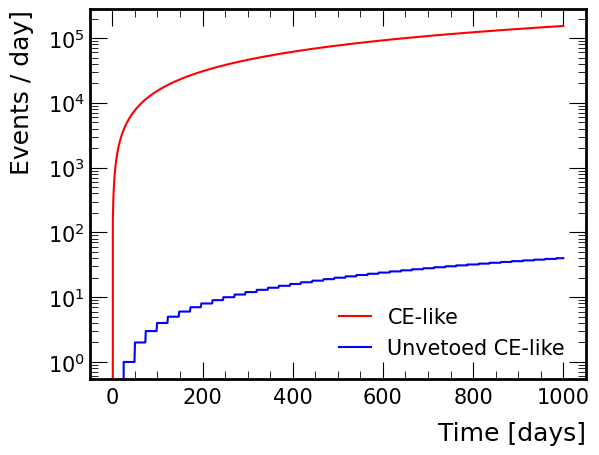

In [4]:
# Calculate the number of events for each time
# Force integers
N_b_t = np.array(rate_b*t, dtype="int")
N_ce_t = np.array(rate_ce*t, dtype="int")

fig, ax = plt.subplots()
ax.plot(t, N_ce_t, label="CE-like")
ax.plot(t, N_b_t, label="Unvetoed CE-like") 
ax.set_xlabel("Time [days]")
ax.set_ylabel("Events / day]")
ax.set_yscale("log")
ax.legend()
plt.show()

## Plot the inefficiency 

/tmp/ipykernel_780429/3409611708.py:2: RuntimeWarning: invalid value encountered in divide
  ineff_int = N_b_t  / N_ce_t


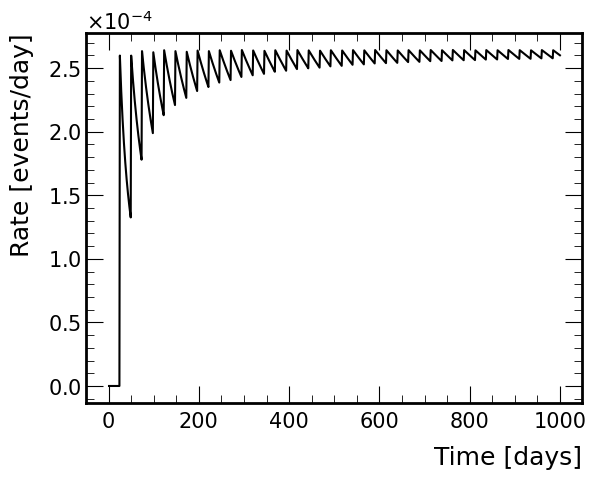

In [5]:
# Calcuate the inefficency
ineff_int = N_b_t  / N_ce_t 

fig, ax = plt.subplots()
ax.plot(t, ineff_int, color="black") 
ax.set_xlabel("Time [days]")
ax.set_ylabel("Rate [events/day]")
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
plt.show()

## Plot the uncertainties

In [6]:
# Find the target time numerically
def get_target_time(t, unc, target=1e-4):
    for i, value in enumerate(unc):
        if np.isnan(value) or value <= 0:
            continue
        if value <= target:
            return t[i]
            
#             # Linear interpolation between points i-1 and i
#             t1, t2 = t[i-1], t[i]
#             u1, u2 = unc[i-1], unc[i]
            
#             # Interpolate to find exact crossing point
#             # target = u1 + (u2 - u1) * (t_target - t1) / (t2 - t1)
#             # Solve for t_target:
#             t_target = t1 + (target - u1) * (t2 - t1) / (u2 - u1)
#             return t_target
    
#     return None  # Never reaches target

In [7]:
# Uncertainties
poisson_unc = poisson(N_b_t, N_ce_t)
poisson_ci = poisson_confidence_interval(N_b_t, N_ce_t)
wilson_unc = wilson(N_b_t, N_ce_t)
# poisson_gamma_ci = poisson_gamma_ci(N_b_t, N_ce_t)

# Target times
poisson_target_time = get_target_time(t, poisson_unc)
poisson_ci_target_time = get_target_time(t, poisson_ci)
# poisson_gamma_ci_target_time = get_target_time(t, poisson_gamma_ci)
wilson_target_time = get_target_time(t, wilson_unc)

/tmp/ipykernel_780429/2989686586.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(k) / (N)
/tmp/ipykernel_780429/2989686586.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  result.append( (upper_lambda - lower_lambda) / (2 * i_N) )
/home/sgrant/.conda/envs/ana_v2.0.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/home/sgrant/.conda/envs/ana_v2.0.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/home/sgrant/.conda/envs/ana_v2.0.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/home/sgrant/.conda/envs/ana_v2.0.0/lib/python3.12/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in divide
  q

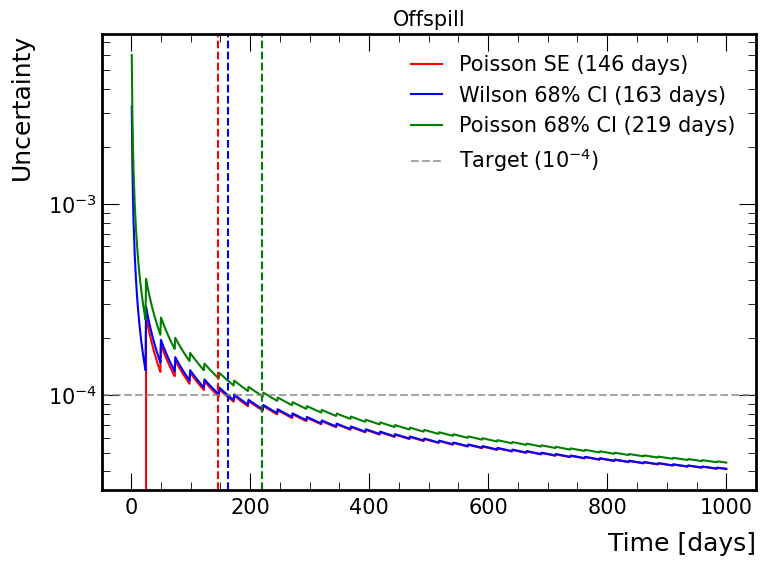

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, poisson_unc, label=f"Poisson SE ({poisson_target_time:.0f} days)") 
ax.plot(t, wilson_unc, label=rf"Wilson 68% CI ({wilson_target_time:.0f} days)") 
ax.plot(t, poisson_ci, label=rf"Poisson 68% CI ({poisson_ci_target_time:.0f} days)") 
# ax.plot(t, poisson_gamma_ci, label=rf"Poisson/Gamma 68% CI ({poisson_gamma_ci_target_time:.0f} days)") 
ax.set_xlabel("Time [days]")
ax.set_ylabel("Uncertainty")
ax.set_title("Offspill")
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)

ax.axvline(poisson_target_time, linestyle="--", color="r")
ax.axvline(wilson_target_time, linestyle="--", color="b")
ax.axvline(poisson_ci_target_time, linestyle="--", color="g")
# ax.axvline(poisson_gamma_ci_target_time, linestyle="--", color="orange")
ax.axhline(1e-4, color="gray", linestyle="--", alpha=0.7, label=r"Target ($10^{-4}$)")

ax.legend()#frameon=True)
ax.set_yscale("log")
plt.tight_layout()
plt.savefig("../../img/models/plt_offspill_comp.png", dpi=300)
plt.show()

So, it looks like Wilson CI is more consistent with the Possion SE, and the Poisson CI is more conservative... 

I think all three are valid, but I like Wilson the best :) 